In [ ]:
from tensorflow.keras.datasets import mnist
import sys

from tqdm import tqdm
from torch import optim
import torch
import matplotlib.pyplot as plt


import torch
from torch import nn

In [85]:
device = 'cuda'

In [ ]:
batch_size = 64
LATENT_DIM = 32
HID_DIM = 32
LR = 2e-4
CRITIC_STEPS = 5
N_EPOCHS = 20
GRAD_WEIGHT = 10


In [79]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train/ 255
X_test = X_test / 255



y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)
X_train = torch.Tensor(X_train).unsqueeze(1)
X_test = torch.Tensor(X_test).unsqueeze(1)
X_train.shape, X_test.shape

train_loader = torch.utils.data.DataLoader(list(zip(X_train, y_train)), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(list(zip(X_test, y_test)), batch_size=batch_size, shuffle=False)

In [80]:
class Generator(nn.Module):
    def __init__(self, latent_dim=LATENT_DIM, hid_dims=HID_DIM):
        super().__init__()
        self.latent_dim = latent_dim
        self.hid_dims = hid_dims
        self.network = nn.Sequential(
            nn.ConvTranspose2d(self.latent_dim, self.hid_dims, 3, 2),
            nn.BatchNorm2d(self.hid_dims),
            nn.ReLU(),
            nn.ConvTranspose2d(self.hid_dims, self.hid_dims * 2, 4, 1),
            nn.BatchNorm2d(self.hid_dims * 2),
            nn.ReLU(),
            nn.ConvTranspose2d(self.hid_dims * 2, self.hid_dims, 3, 2),
            nn.BatchNorm2d(self.hid_dims),
            nn.ReLU(),
            nn.ConvTranspose2d(self.hid_dims, 1, 4, 2),
            nn.Tanh(),
        )
    
    def forward(self, z):
        z = z.view(len(z), self.latent_dim, 1, 1)
        z = self.network(z)
        return z
    
gen = Generator()
gen(torch.randn(64, LATENT_DIM)), sum([p.numel() for p in gen.parameters() if p.requires_grad])


(tensor([[[[ 3.6630e-02,  1.3197e-01, -4.8715e-02,  ..., -3.0092e-02,
            -1.2783e-01, -1.2065e-01],
           [-2.2554e-02, -3.5303e-02,  1.1460e-01,  ...,  1.7438e-01,
             5.6626e-02,  3.5548e-02],
           [-1.2449e-01,  3.1845e-02, -9.6485e-02,  ..., -3.4576e-01,
             5.8253e-02, -3.5985e-01],
           ...,
           [ 5.2740e-02, -9.1445e-03,  3.9190e-02,  ...,  8.1250e-02,
            -1.2152e-02, -1.3091e-01],
           [-1.2013e-01, -8.5600e-02, -7.6130e-02,  ..., -1.8821e-01,
            -2.5816e-02, -1.0839e-01],
           [ 1.7529e-02,  2.4086e-02, -1.0760e-01,  ..., -7.3924e-02,
            -1.5665e-01, -2.1296e-01]]],
 
 
         [[[-2.3667e-02,  2.0888e-01,  1.6229e-01,  ...,  1.3464e-01,
            -6.1966e-02, -6.6369e-02],
           [ 3.6065e-02, -1.5638e-01,  1.8400e-01,  ...,  1.2572e-01,
             8.3558e-02,  1.2665e-01],
           [-3.4622e-02,  4.1764e-02, -6.2374e-02,  ..., -1.6713e-01,
             9.7687e-02, -2.8799e-01

In [81]:
class Critic(nn.Module):
    def __init__(self, latent_dim=LATENT_DIM, hid_dims=HID_DIM):
        super().__init__()
        self.latent_dim = latent_dim
        self.hid_dims = hid_dims
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=hid_dims, kernel_size=4, stride=2),
            nn.BatchNorm2d(hid_dims),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=hid_dims, out_channels=hid_dims * 2, kernel_size=4, stride=2),
            nn.BatchNorm2d(2 * hid_dims),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=2 * hid_dims, out_channels=1, kernel_size=4, stride=2),
        )
    
    def forward(self, x):
        x = self.network(x)
        return x

In [ ]:

crit = Critic().to(device)
gen = Generator().to(device)

opt_gen = optim.Adam(params=gen.parameters(), betas=(0.5, 0.999))
opt_crit = optim.Adam(params=crit.parameters(), betas=(0.5, 0.999))


critic_loss_hist, gen_loss_hist = [], []


for _ in (pbar := tqdm(range(N_EPOCHS))):
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        
        for _ in range(CRITIC_STEPS):
            mean_critic_loss = 0
            batch_size = len(data)
            opt_crit.zero_grad()
            fake_samples = gen(torch.randn(batch_size, LATENT_DIM, device=device))
            crit_fake_preds = crit(fake_samples)
            crit_real_preds = crit(data)

            # Grad to mixed images
            epsilon = torch.rand(batch_size, 1, 1, 1, requires_grad=True, device=device)
            mixed_images = data * epsilon + fake_samples * (1 - epsilon)
            mixed_scores = crit(mixed_images)
            grads = torch.autograd.grad(
                inputs=mixed_images,
                outputs=mixed_scores,
                grad_outputs=torch.ones_like(mixed_scores),
                create_graph=True,
                retain_graph=True
            )[0]
            grad_norm = grads.flatten(1).norm(2, dim=1)
            grad_penanlty = torch.mean((grad_norm - 1) ** 2)
            critic_loss = crit_fake_preds.mean() - crit_real_preds.mean() + GRAD_WEIGHT * grad_penanlty
            critic_loss.backward()
            opt_crit.step()
            mean_critic_loss += critic_loss.detach().cpu().item()
        critic_loss_hist.append(mean_critic_loss)

        opt_gen.zero_grad()
        fake_samples = gen(torch.randn(batch_size, LATENT_DIM, device=device))
        crit_fake_preds = crit(fake_samples)
        generator_loss = - crit_fake_preds.mean()
        generator_loss.backward()
        generator_loss = generator_loss.detach().cpu().item()
        gen_loss_hist.append(generator_loss)
        opt_gen.step()


    pbar.set_description(f'{generator_loss=},{mean_critic_loss=}')

plt.plot(gen_loss_hist, label='gen')
plt.plot(critic_loss_hist, label='critic')
plt.legend();



for i in range(5):
    plt.imshow(fake_samples[i].squeeze().cpu().detach().numpy())
    plt.show()

generator_loss=-120.30770111083984,mean_critic_loss=-286.3764953613281:  60%|██████    | 6/10 [12:13<08:08, 122.21s/it]


KeyboardInterrupt: 

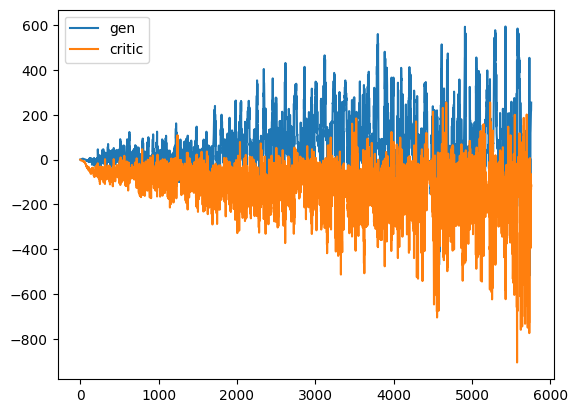

In [84]:
plt.plot(gen_loss_hist, label='gen')
plt.plot(critic_loss_hist, label='critic')
plt.legend();


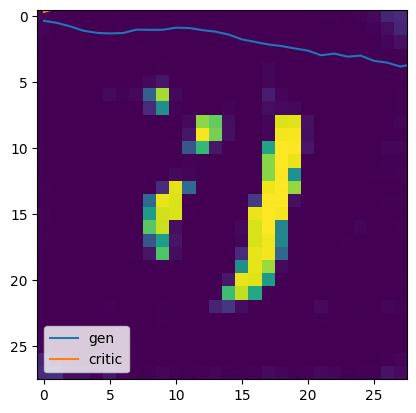

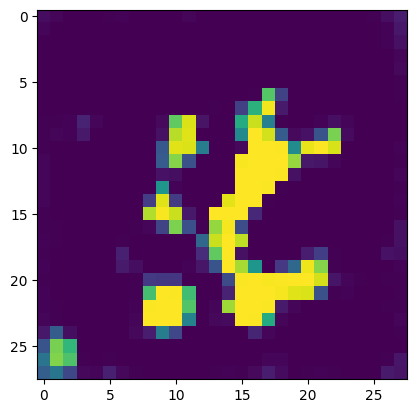

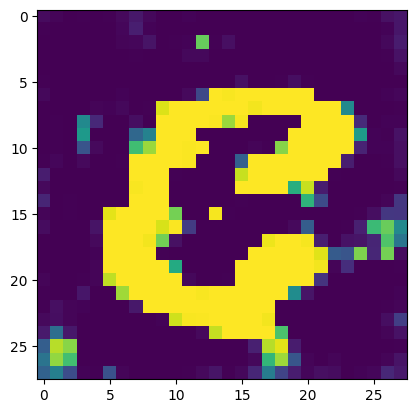

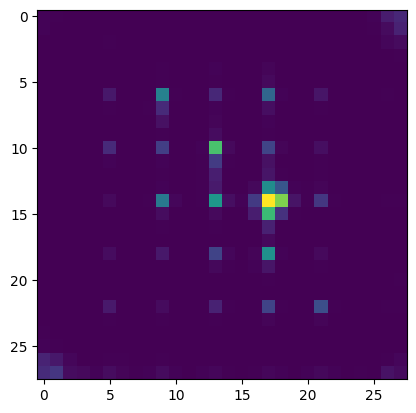

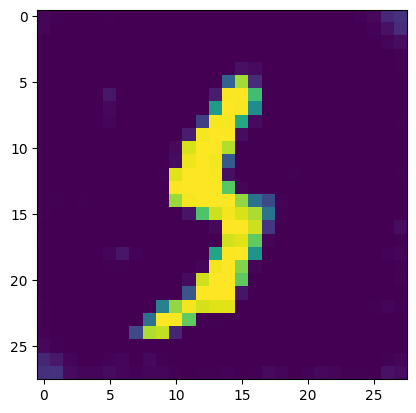

In [ ]:



for i in range(5):
    plt.imshow(fake_samples[i].squeeze().detach().numpy())
    plt.show()